# INF8111 - Fouille de données 
## Summer 2020 - TP3 - Fouille de réseaux sociaux
### Team member
    - Kacem Khaled ()
    - Oumayma Messoussi ()
    - Semah Aissaoui ()



## Directives de remise
The work will be carried out with the same team as for the previous TPs.
You must put back in the submission box on moodle:

1. this file renamed TP3\_NomDuMembre1\_NomDuMembre2\_NomDuMembre3.ipynb

**N.B**: Make sure that all results are there when you open your notebook.

Everything must be submitted before **20 juin 2020 à 23h55**. Any late work will be penalized with a value of 10% per day of delay.

## Barème
Partie 1: 12 points

Partie 2: 8 points

For a total of 20 points on 20 points.


## Social networks
Social networks are a major component of the humain life. Each person belongs throughout their life to different communities. With the aggregation of information on various online social media platforms, data analysts were interested in exploiting its data. It is a relatively new field that is growing with impacts on several aspects such as advertising and recommendation systems.


### Goal
The purpose of this lab is to give you an overview of social network analysis.

In the first part, you will implement an algorithm for detecting communities in a social network called LPAm+. This algorithm was proposed by [X. Liu and T. Murata in 2010](https://www.sciencedirect.com/science/article/pii/S0378437109010152).

In the second part, you will find the people with the most influence in their social network.

For both parties, we provide you with all the csv containing the social networks to be analyzed.


# 1. LPAm+ (12 points)


## Community detection
Community detection in a social network is a frequent manipulation when analyzing a network. A clustering method is used to bring people together in communities according to the links between them.


## LPAm+
In this part, you will implement the LPAm+ algorithm to detect the communities among the characters of Games of Thrones. You must use the nodes and edges csv for this.

This algorithm consists in propagating the labels in the network according to an evaluation rule optimizing the modularity of the network. When the algorithm reaches a local optimum, it checks whether it can combine two communities to increase the modularity of the network. The algorithm always chooses the most advantageous combination. If a combination is found, the propagation of the labels is redone. The algorithm continues until it is no longer able to increase modularity. You can read the article mentioned above for more details but you don't need to as you will be guided throughout the TP.


You can read more about the package [here](https://networkx.github.io/documentation/stable/tutorial.html).

In [45]:
# you can also use anacondas to install the package instead
!pip install --user numpy
!pip install --user pandas
!pip install --user matplotlib
!pip install --user networkx
!pip install python-modularity-maximization==0.0.1rc4

In [47]:
import numpy as np
import networkx as nx
import random
import itertools
import math
import copy
from itertools import combinations


class LPAmPlus:
    """
    Contructeur
    """

    def __init__(self, graph):
        """
        graph gives the graph on which the algorithm will be applied;
        """
        self.graph = graph

        """
        labels gives all the communities present in the network
        """
        self.labels = []

        """
        Assign a label to each node
        """
        for count,node in enumerate(list(self.graph.nodes)):
            self.graph.nodes[node]['label']=count
            self.labels.append(count)

    """
    Term to optimize when replacing labels
    """
    def label_evaluation(self, current_node, new_label):
        nodes=self.graph.nodes
        # Index current node
        index_current_node=list(nodes).index(current_node)
        # Compute the modularity matrix 
        B = nx.modularity_matrix(self.graph)
        lmax=0
        for u,node_u in enumerate(nodes):
            if node_u == current_node:
                continue
            lmax+=B[u,index_current_node] * int(nodes[node_u]['label']==new_label)
        return lmax
    

    """
    Function to choose the new label for a node
    """

    def update_label(self, current_node):
        node_label={}
        for label in self.labels:
            node_label.setdefault(label,self.label_evaluation(current_node,label))
        max_label=max(node_label,key=node_label.get)
        self.graph.nodes[current_node]['label']= max_label
            

    """
    Function that calculates the current modularity of the network
    """

    def modularity(self):
        # Compute the modularity matrix 
        B = nx.modularity_matrix(self.graph)
        # Compute m
        m=self.graph.number_of_edges()
        # Compute n
        n=self.graph.number_of_nodes()
        Q=0
        nodes = self.graph.nodes
        for u, node_u in enumerate(nodes):
            for v, node_v in enumerate(nodes):
                if nodes[node_u]['label']== nodes[node_v]['label']:
                    Q+=B[u,v]
        Q/=(2*m)
        return Q
    
    """
    Function that applies the LPAm algorithm on the network
    """

    def LPAm(self):
        Community_number=5
        i=0
        while(i<Community_number):
            for n in self.graph.nodes:
                # Compute modularity
                mod=self.modularity()
                # copy the graph
                aux_graph=copy.deepcopy(self.graph)
                # Update label node
                self.update_label(n)
                self.labels=list(dict.fromkeys(list(nx.get_node_attributes(self.graph, 'label').values())))
                if self.modularity()==mod:
                    i+=1
                elif self.modularity()<mod:
                    self.graph=aux_graph
                    #self.labels=list(dict.fromkeys(list(nx.get_node_attributes(self.graph, 'label').values())))
                    return 
                else:
                    i=0
    
   
    """
    Function that find which communities to combine and combine them
    """
    def merge_communities(self):
        init_mod=self.modularity()
        # Possible label_combinations
        label_combinations=list(combinations(self.labels, 2))
        aux_graph=copy.deepcopy(self.graph)
        aux_labels=copy.deepcopy(self.labels)
        comb_dic={}
        for c in label_combinations:
            self.labels.remove(c[1])
            list_label_node=[node for node in self.graph.nodes if self.graph.nodes[node]['label']==c[1]]
            for node in list_label_node:
                self.graph.nodes[node]['label']=c[0]
            comb_dic.setdefault(c,self.modularity())
            self.graph=copy.deepcopy(aux_graph)
            self.labels=copy.deepcopy(aux_labels)
        # Best combination that gives best modularity value
        best_combination_mod=max(comb_dic,key=comb_dic.get)
        if comb_dic[best_combination_mod]>init_mod:
            self.labels.remove(best_combination_mod[1])
            list_label_node=[node for node in self.graph.nodes if self.graph.nodes[node]['label']==best_combination_mod[1]]
            for n in list_label_node:
                self.graph.nodes[n]['label']=best_combination_mod[0]
            return True
            
        else:
            return False
    
    
    """
    Function that applies the LPAm+ algorithm on the network
    """

    def find_communities(self):
      self.LPAm()
      while self.merge_communities():
          self.LPAm()
    


### 1.1 Dataset (1 point)

We have provided you with the csv for all the seasons of Games of Thrones. You must now represent each of those networks in code using two csv for each season: the one for the nodes and the one for the edges.


#### Implémentation
1. Implement the function *`load_unweighted_network`*. This function returns a undirected and unweighted graph.

Use the function `test_load` to verify your implementation of the function. This test use a toy dataset. You should obtain a result similar to this:
![title](data/picture.png)

In [48]:
import pandas as pd
df_nodes=pd.read_csv('data/toy-nodes.csv')
df_nodes.head()

,Id,Label,Community
0,0,node_0,0
1,1,node_1,0
2,2,node_2,0
3,3,node_3,0
4,4,node_4,0


In [49]:
df_edges=pd.read_csv('data/toy-edges.csv')
df_edges.head()

,Source,Target
0,1,0
1,2,0
2,3,0
3,7,0
4,2,1


In [50]:
import csv
import pandas as pd
import networkx as nx


def load_unweighted_network(node_csv, edge_csv):
    df_nodes=pd.read_csv(node_csv)
    df_edges=pd.read_csv(edge_csv)
    G=nx.Graph()
    G.add_nodes_from(df_nodes.Id)
    G.add_edges_from(zip(df_edges.Source, df_edges.Target))
    if 'Community' in df_nodes:
      for i, item in enumerate(list(G.nodes)):
        G.nodes[item]['ground_truth'] = df_nodes.Community[i]
    return G

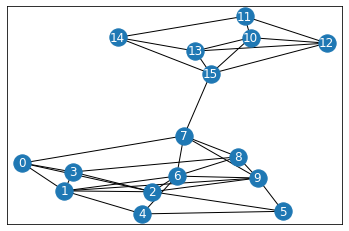

In [51]:
import matplotlib.pyplot as plt
def test_load():
    network = load_unweighted_network("data/toy-nodes.csv", "data/toy-edges.csv")
    nx.draw_networkx(network,font_color='white')
    plt.show()

test_load()

### 1.2  Modularity (1 point)

The modularity $Q$ of the network is an important measure for the algorithm. The algorithm uses it to determine if it reached a local optimum or not. $$ Q=\frac{1}{2m}\sum_{u,v=1}^n B_{uv}\delta(l_u,l_v)$$ 

- m: number of edges
- l: node's label
- u, v: nodes in the graph
- B: modularity matrix where each element is $A_{uv} - P_{uv}$
- $A_{uv}$: is 1 if there is an edge between u and v else 0
- $P_{uv}$: probability that there is an edge between u and v following the null model $$P_{uv}=\frac{degree(u)*degree(x)}{2m}$$
- $\delta(l_u,l_v)$: Kronecker's delta, is 1 if labels are the same else 0

The modularity can also be defined like this: $$Q=\sum_{t=1}^{N_c}\left(\frac{I_t}{m}-\left(\frac{D_t}{2m}\right)^2\right)$$

- m: number of edges
- Nc: the number of community in the graph
- t: a community in the graph
- $I_t$: the number of arc in the community t meaning all arcs that have both nodes in the community t
- $D_t$: the sum of degree of all the nodes in the community t

#### Implementation
1. Implement the function `modularity` in the class LPAmPlus. This function returns the modularity of the network. You can use the function `linalg.modularity_matrix` from networkx to calculate B. You can implement whichever definition for the modularity. **N.B:** You can add data to nodes with Networkx to store information about the node.

Use the function `test_modularity` to test your implementation. You should have a modularity of 0.413.

In [52]:
def test_modularity():
    social_network = load_unweighted_network("data/toy-nodes.csv", "data/toy-edges.csv")
    lpam = LPAmPlus(social_network)
    lpam.labels = [0, 1]
    for i in [0,1,2,3,4,5,6,7,8,9]:
        lpam.graph.nodes[i]['label'] = 0
    for i in [10,11,12,13,14,15]:
        lpam.graph.nodes[i]['label'] = 1
    print("Modularity: {}".format(lpam.modularity()))

test_modularity()

Modularity: 0.41265306122448997


### 1.3 Updating rule for the labels (2 points)

As mentioned above, the algorithm is strongly based on its optimization of modularity. You are now asked to implement the term to optimize. The new label $l_x^{new}$ corresponds to the label for which the sum gives the greatest value.
$$l_x^{new}=\arg\max\sum_{u=1}^n B_{ux}\delta(l_u,l)$$

- n: number of nodes
- m: number of edges
- l: node's label
- x: current node being evaluated
- u: another node in the network (starts at 1, because we exclude the node x)
- B: modularity matrix where each element is $A_{ux} - P_{ux}$
- $A_{ux}$: is 1 if there is an edge between u and x else 0
- $P_{ux}$: the probability that there is an edge between u and x  following the null model  $$P_{ux}=\frac{degree(u)*degree(x)}{2m}$$
- $\delta(l_u,l)$: Kronecker's delta, is 1 if labels are the same else 0


#### Implementation
1. Implement the function `label_evaluation`. This function returns the value for the term to optimize. You can use the function `linalg.modularity_matrix` from networkx to calculate B. It is normal if there is a similarity with the modularity depending on the definition you took.
2. Implement the function `update_label`. This function chooses the new label for the current node. If there is more than one label with the max value, the function chooses randomly one amoung those. Don't forget to remove the unused labels from the `labels` attribute. **N.B:**  You can add data to nodes with Networkx to store information about the node.


### 1.4 LPAm (3 points)

You can now implement the LPAm algorithm. This algorithm is the predecessor of LPAm +. He begins by giving a unique label to each node. It then explores all the nodes and changes their label according to the evaluation function that you implemented earlier. The algorithm continues until it can no longer improve the modularity of the network.

#### Implementation
1. Initialise the `labels` attribute from LPAmPlus and add the those labels to the nodes in the graph in the function `__init__`.

2. Implement the LPAm algorithm in the function`LPAm`. Make sure that all your label's changes improve the modularity.

Use the function `test_lpam` to verify your implementation. You should have a modularity of 0.399 with 4 communities.

In [53]:
def test_lpam():
    social_network = load_unweighted_network("data/toy-nodes.csv", "data/toy-edges.csv")
    lpam = LPAmPlus(social_network)
    lpam.LPAm()
    print("Modularity: {}\nCommunities: {}".format(lpam.modularity(), lpam.labels))

test_lpam()

Modularity: 0.39877551020408175
Communities: [3, 5, 8, 11]


### 1.5 LPAm+ (2 point)

You can now fully implement LPAm+. When LPAm falls into a local optimum, LPAm+ tries to combine two communities to increase modularity. LPAm+ chooses the combination that most increases modularity and redo the label's propagation until the next local optimum. The algorithm continues until it can no longer increase modularity.

#### Implementation
1. Implement the function  `merge_communities`. This function check if combining communities improve the modularity and combine the best choice. It returns True if a combinaison was made else False.
2. Implement the LPAM+ algorithm in the function `find_communities`.

Use the function `test_lpam_plus` to verify your implementation. You should end with a modularity of 0.413 and 2 communities.

In [54]:
def test_lpam_plus():
    social_network = load_unweighted_network("data/toy-nodes.csv", "data/toy-edges.csv")
    lpam = LPAmPlus(social_network)
    lpam.find_communities()
    print("Modularity: {}\nCommunities: {}".format(lpam.modularity(), lpam.labels))

test_lpam_plus()

Modularity: 0.41265306122448997
Communities: [3, 11]


### 1.6 GOT dataset (4 points)

Run your algorithm over the Games of Thrones data from each season and compare what you get and the real communities. 

Start by calculating the RI (Rand index) of your results. $$ RI=\frac{TP+TN}{TP+TN+FP+FN} = \frac{TP+TN}{\binom{n}{2}}$$

- n: number of nodes
- TP: True positive the number of pairs of elements that are in the same community in your results and in the ground truth
- TN: True negative the number of pairs of elements that are in different communities in your results and in the ground truth
- FP: False positive the number of pairs of elements which are in the same community in your results but which are in different communities in the ground truth
- FN: False negative the number of pairs of elements which are in different communities in your results but which are in the same community in the ground truth

Does the algorithm perform well on all seasons or for some only? Why did the algorithm perform like that? You can do the manipulations you want to better present your results and better support your statements.

### Results

Season 1 Ground Truth Clustering:


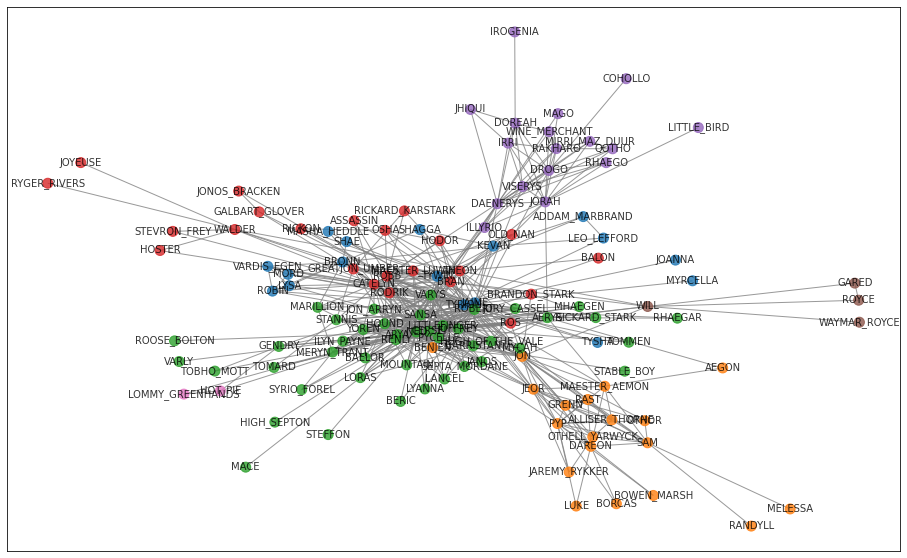

Season 1 Predicted Clustering:


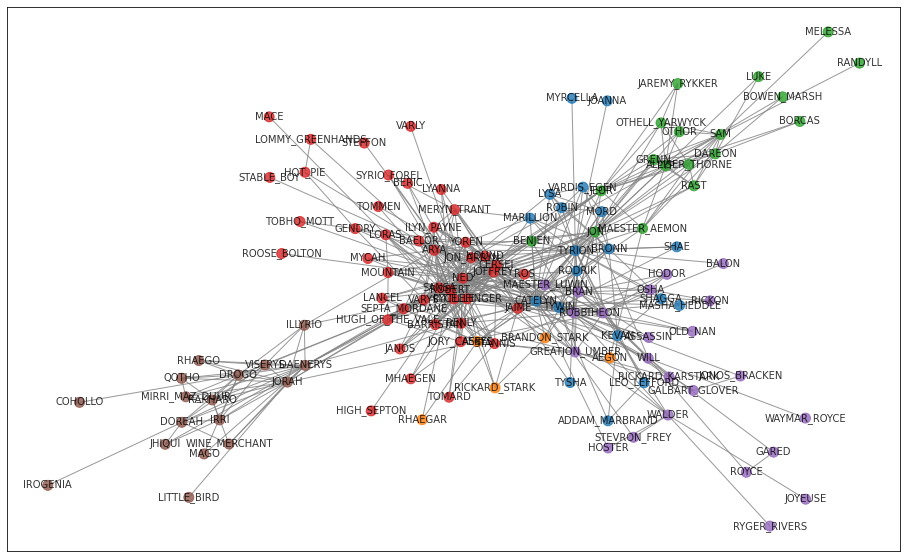

Season: 1
Modularity: 0.4531089810584543
Communities: [53, 62, 78, 35, 13, 64]
	Number of found communities: 6    
Real Communities: ['Lannister', 'Night Watch', "King's Landing", 'Stark', 'Dothraki', 'Doomed Night Watch', 'Orphan']
	Real number of communities: 7
TP: 1371	TN: 5928	FP: 298	FN: 278    
Rand Index: 0.9268571428571428

Precision: 0.8214499700419413	Recall: 0.8314129775621589

-----------------------------------------



Season 2 Ground Truth Clustering:


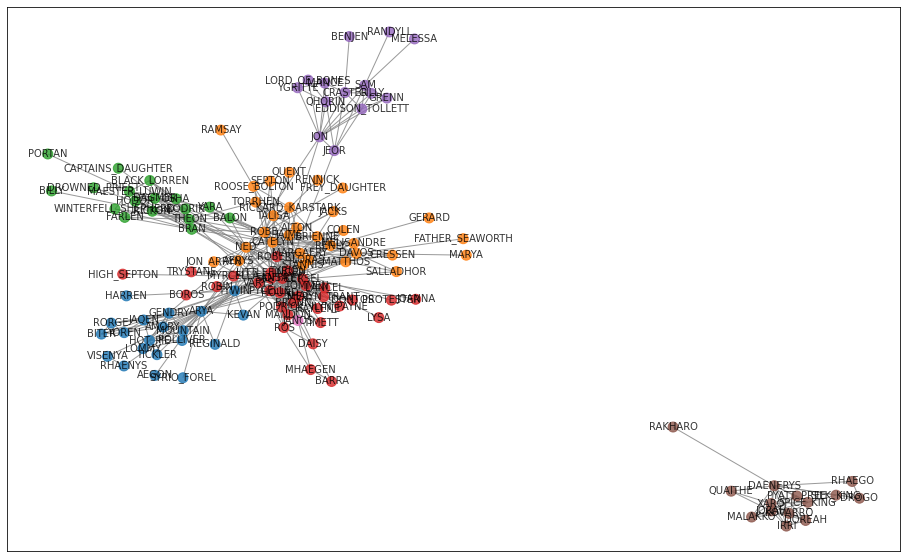

Season 2 Predicted Clustering:


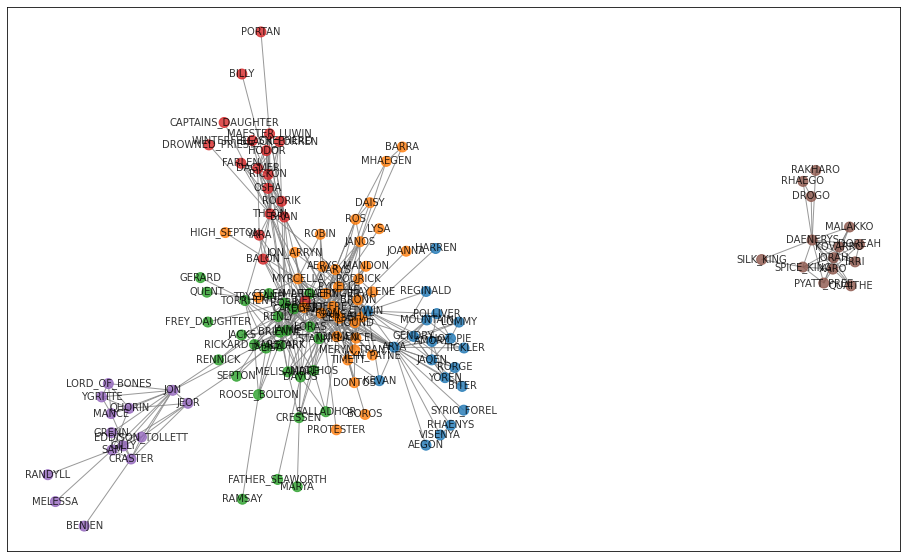

Season: 2
Modularity: 0.5692983793120965
Communities: [78, 116, 45, 126, 36, 44]
	Number of found communities: 6    
Real Communities: ['Harenhall', 'Riverlands and Stormlands', 'Iron Islands and Winterfell', "King's Landing", 'Far North', 'Red Waste and Qarth', 'Janos']
	Real number of communities: 7
TP: 1383	TN: 6672	FP: 115	FN: 86    
Rand Index: 0.9756540697674418

Precision: 0.9232309746328438	Recall: 0.9414567733151804

-----------------------------------------



Season 3 Ground Truth Clustering:


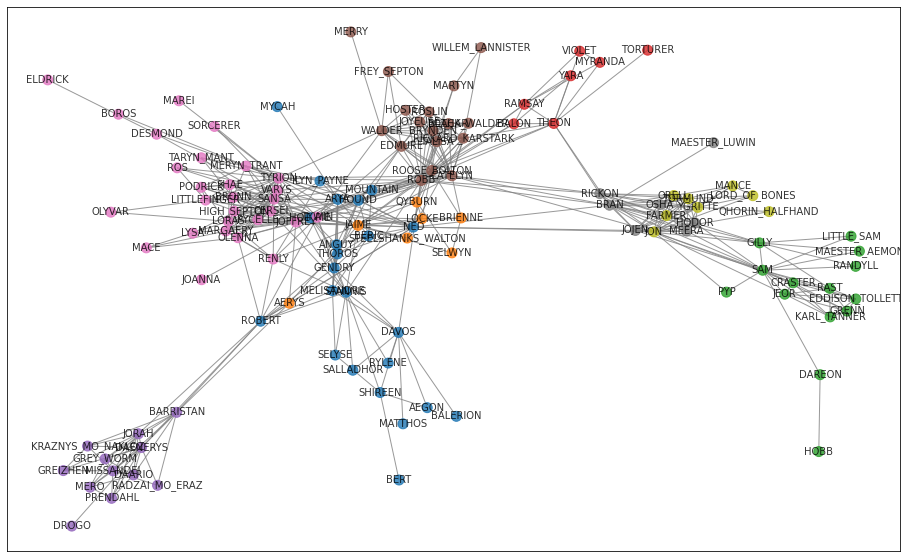

Season 3 Predicted Clustering:


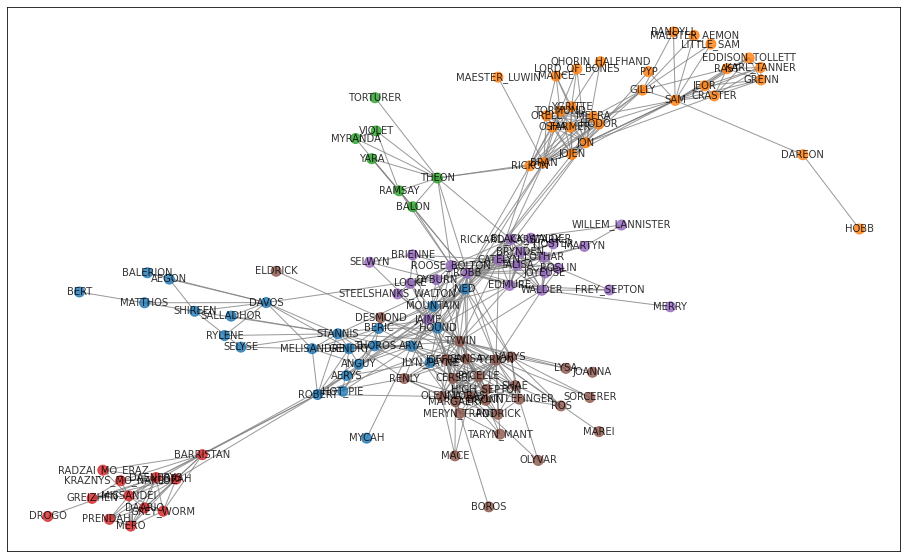

Season: 3
Modularity: 0.6273571054427709
Communities: [105, 31, 118, 86, 49, 110]
	Number of found communities: 6    
Real Communities: ['Dragonstone', "Kingslayer's trek", "Craster's keep", "Theon's imprisonment", 'Accross the Narrow Sea', 'Stark Bannermen', "King's Landing", 'The North', 'Beyond the Wall']
	Real number of communities: 9
TP: 1009	TN: 6097	FP: 391	FN: 6    
Rand Index: 0.9470878315340531

Precision: 0.7207142857142858	Recall: 0.994088669950739

-----------------------------------------



Season 4 Ground Truth Clustering:


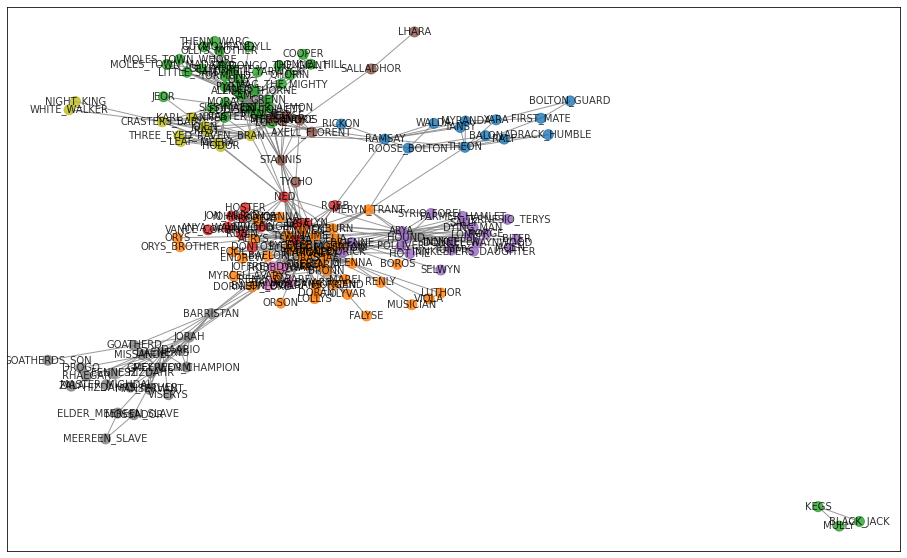

Season 4 Predicted Clustering:


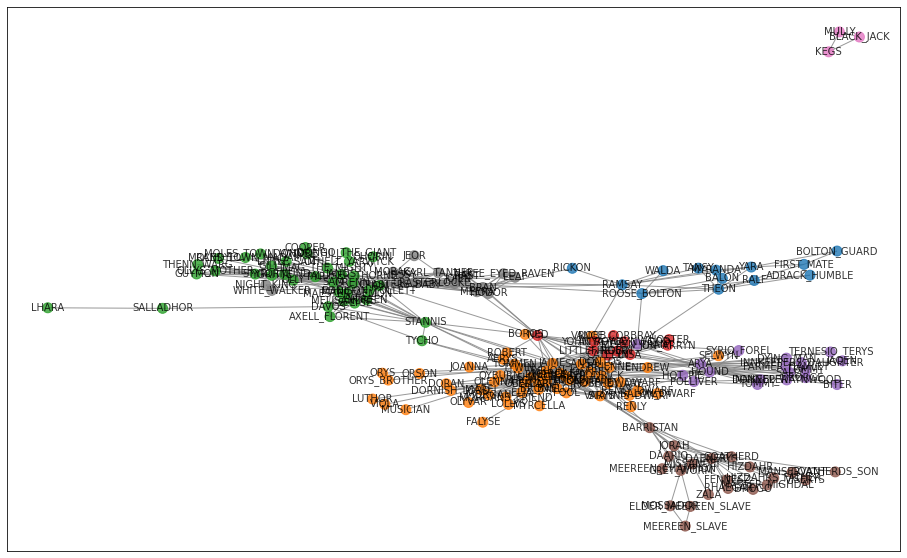

Season: 4
Modularity: 0.6071679787895999
Communities: [134, 49, 91, 66, 139, 89, 69, 70]
	Number of found communities: 8    
Real Communities: ['Winterfell', "King's Landing", 'Castle Black', 'Eyrie', 'Riverlands', 'Dragonstone', 'Dwarf Troup', 'Meereen', 'Beyond the wall']
	Real number of communities: 9
TP: 1843	TN: 11510	FP: 827	FN: 355    
Rand Index: 0.9186790505675955

Precision: 0.6902621722846441	Recall: 0.8384895359417652

-----------------------------------------



Season 5 Ground Truth Clustering:


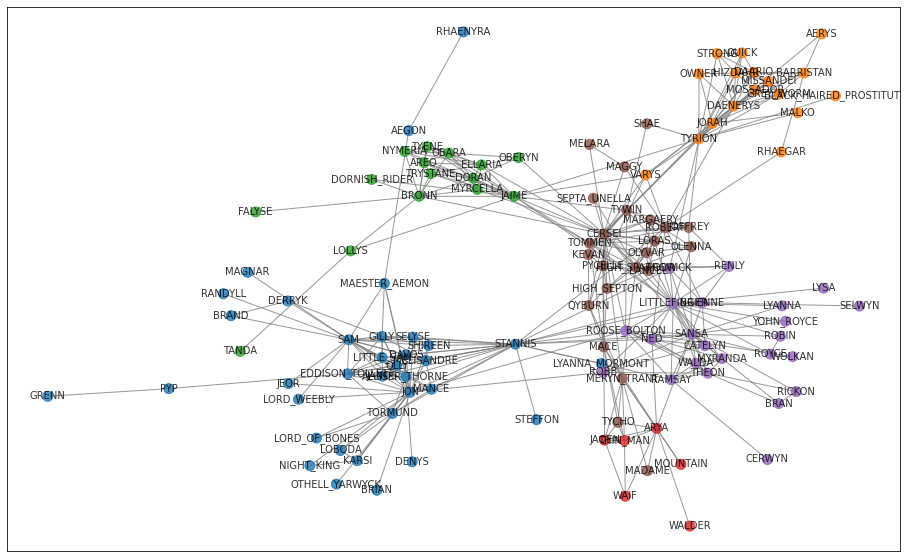

Season 5 Predicted Clustering:


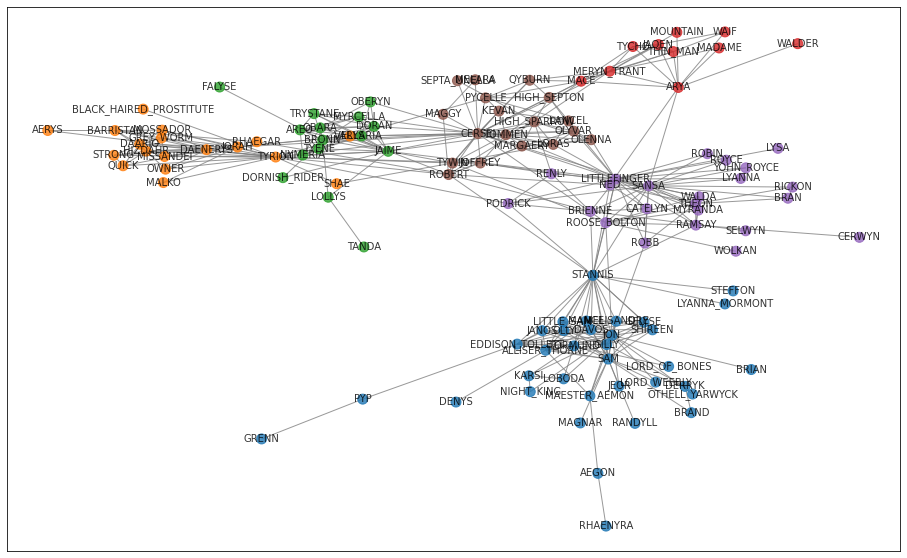

Season: 5
Modularity: 0.6701165697377894
Communities: [85, 79, 69, 113, 114, 72]
	Number of found communities: 6    
Real Communities: ["Night's Watch", 'Essos', 'Dorne', 'Braavos', 'Winterfell', "King's Landing"]
	Real number of communities: 6
TP: 1263	TN: 5623	FP: 41	FN: 94    
Rand Index: 0.9807719698048711

Precision: 0.968558282208589	Recall: 0.9307295504789977

-----------------------------------------



Season 6 Ground Truth Clustering:


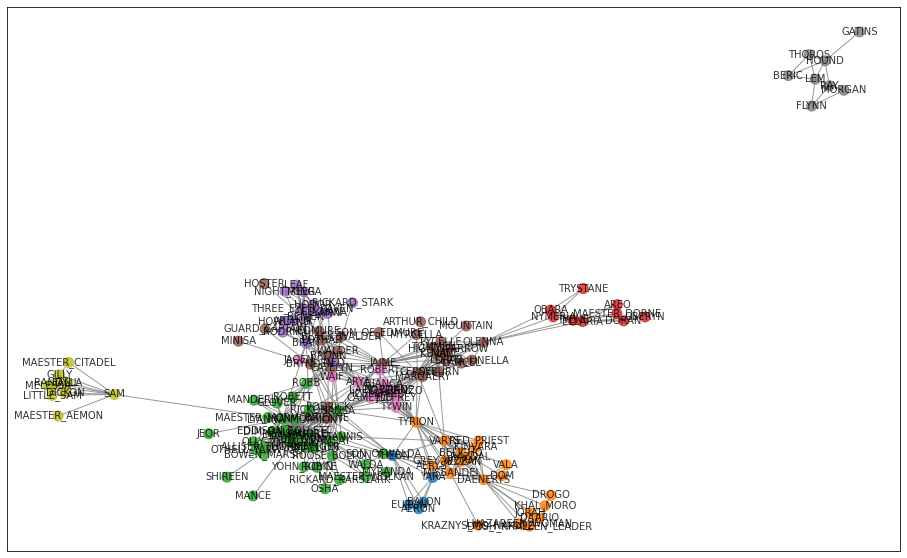

Season 6 Predicted Clustering:


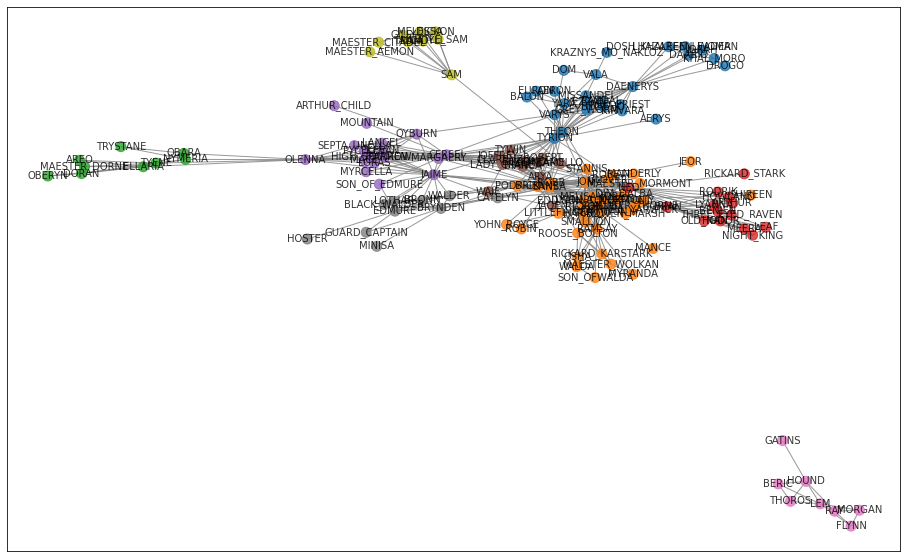

Season: 6
Modularity: 0.655484981942791
Communities: [7, 95, 73, 47, 117, 19, 125, 67, 80]
	Number of found communities: 9    
Real Communities: ['Ironborn', 'Essos', 'North', 'Dorne', 'Beyond the wall', "King's Landing", 'Braavos', 'Riverlands', 'Oldtown']
	Real number of communities: 9
TP: 1269	TN: 8346	FP: 172	FN: 224    
Rand Index: 0.9604435121366497

Precision: 0.8806384455239417	Recall: 0.8499665103817816

-----------------------------------------



Season 7 Ground Truth Clustering:


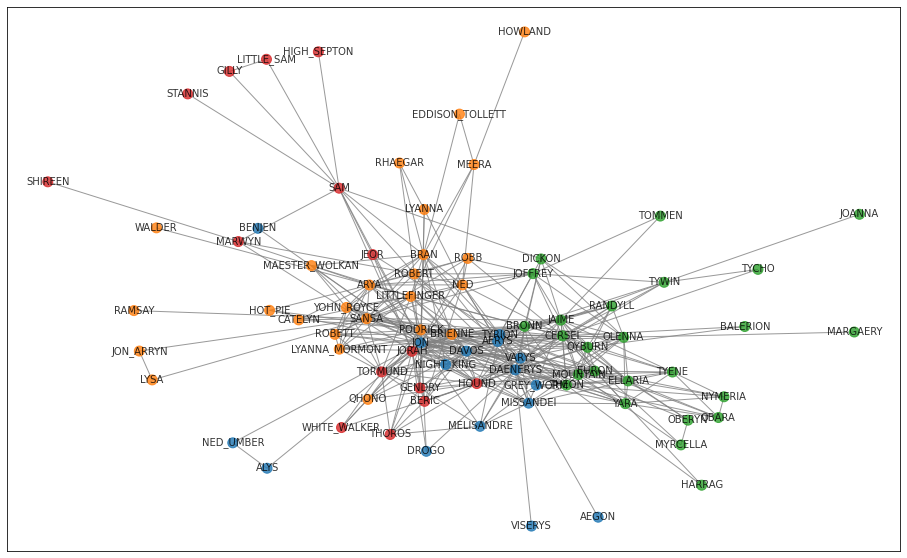

Season 7 Predicted Clustering:


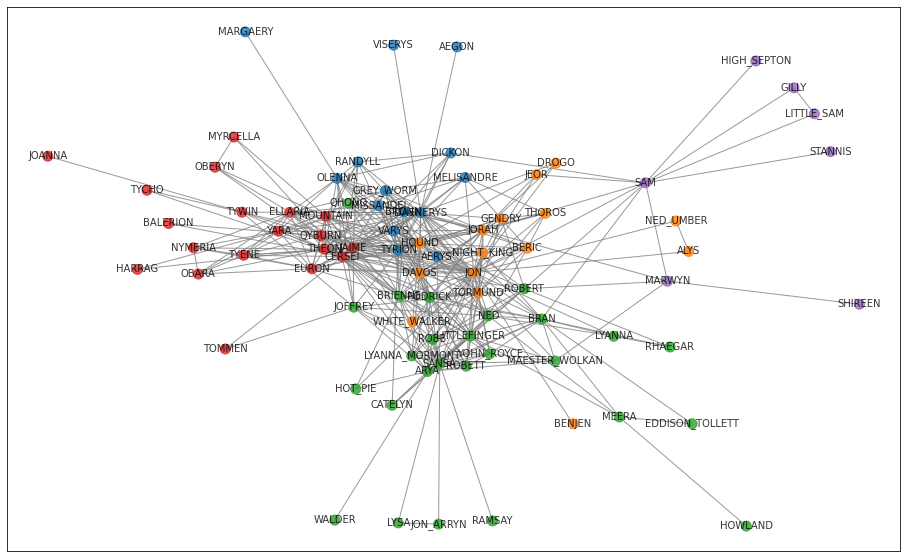

Season: 7
Modularity: 0.3211394806296525
Communities: [57, 47, 37, 55, 34]
	Number of found communities: 5    
Real Communities: ['Dragonstone', 'Winterfell', "King's Landing", 'Northen Expedition']
	Real number of communities: 4
TP: 587	TN: 2289	FP: 126	FN: 238    
Rand Index: 0.8876543209876543

Precision: 0.82328190743338	Recall: 0.7115151515151515

-----------------------------------------



Season 8 Ground Truth Clustering:


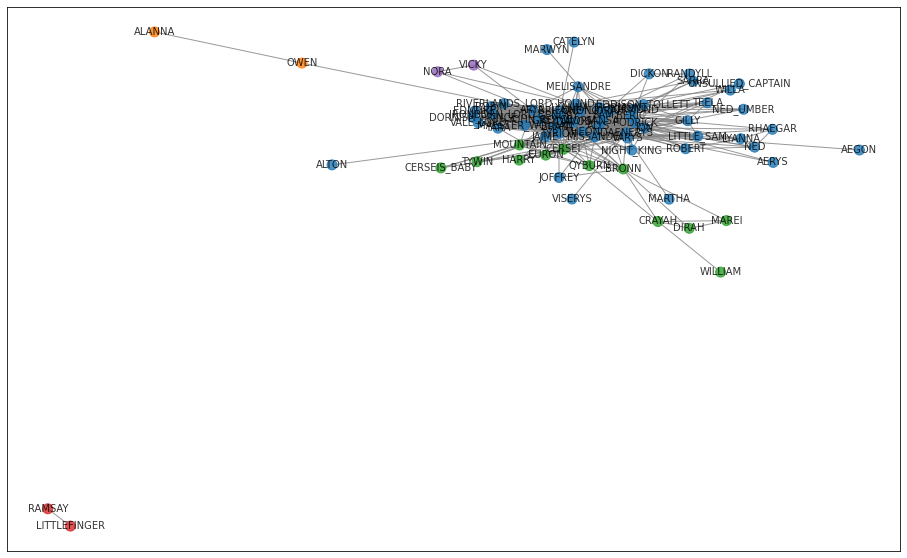

Season 8 Predicted Clustering:


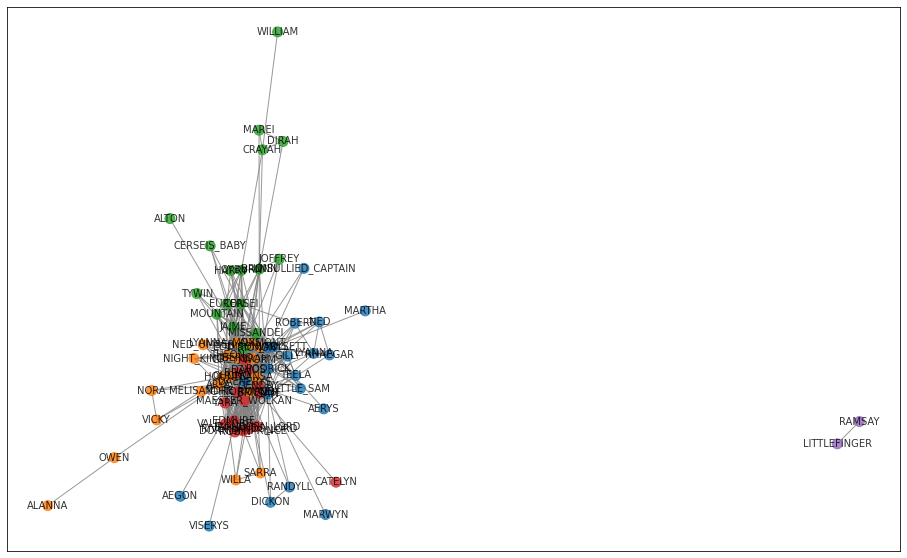

Season: 8
Modularity: 0.2088182492993989
Communities: [14, 46, 12, 20, 50]
	Number of found communities: 5    
Real Communities: ['Stark/Targaryen', 'Citizen pair 1', "King's Landing", 'Other', 'Citizen pair 2']
	Real number of communities: 5
TP: 494	TN: 964	FP: 128	FN: 1115    
Rand Index: 0.5398000740466494

Precision: 0.7942122186495176	Recall: 0.3070229956494717

-----------------------------------------





In [89]:
# Put your code here
for i in range(1,9):
    nodes_csv = "data/got-s{}-nodes.csv".format(i)
    edges_csv = "data/got-s{}-edges.csv".format(i)
    social_network = load_unweighted_network(nodes_csv, edges_csv)
    fig = plt.figure(figsize=(16,10))
    color_map = []
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    labels = list(dict.fromkeys(list(nx.get_node_attributes(social_network, 'ground_truth').values())))
    for node in list(social_network.nodes):
        color_map.append(colors[labels.index(social_network.nodes[node]['ground_truth'])])
    print('Season {} Ground Truth Clustering:'.format(i))
    nx.draw_networkx(social_network,node_color=color_map,node_size=100,alpha=0.8,font_color='k',font_size=10,edge_color='gray')
    plt.show()
    lpam = LPAmPlus(social_network)
    lpam.find_communities()
    nodes = lpam.graph.nodes
    TP = 0 # True positive the number of pairs of elements that are in the same community in your results and in the ground truth
    TN = 0 # True negative the number of pairs of elements that are in different communities in your results and in the ground truth
    FP = 0 # False positive the number of pairs of elements which are in the same community in your results but which are in different communities in the ground truth
    FN = 0 # False negative the number of pairs of elements which are in different communities in your results but which are in the same community in the ground truth
    true_labels = list(dict.fromkeys(list(nx.get_node_attributes(lpam.graph, 'ground_truth').values())))
    fig2 = plt.figure(figsize=(16,10))
    color_map = []
    for node in list(nodes):
        color_map.append(colors[lpam.labels.index(nodes[node]['label'])])
    print('Season {} Predicted Clustering:'.format(i))
    nx.draw_networkx(lpam.graph,node_color=color_map,node_size=100,alpha=0.8,font_color='k',font_size=10,edge_color='gray')
    plt.show()
    for nodes_combination in combinations(list(nodes), 2):
        node_0_label = nodes[nodes_combination[0]]['label']
        node_1_label = nodes[nodes_combination[1]]['label']
        node_0_true_label = nodes[nodes_combination[0]]['ground_truth']
        node_1_true_label = nodes[nodes_combination[1]]['ground_truth']
        if    (node_0_label == node_1_label) and (node_0_true_label == node_1_true_label): TP +=1
        elif  (node_0_label != node_1_label) and (node_0_true_label != node_1_true_label): TN +=1
        elif  (node_0_label == node_1_label) and (node_0_true_label != node_1_true_label): FP +=1
        elif  (node_0_label != node_1_label) and (node_0_true_label == node_1_true_label): FN +=1
    print("Season: {}\nModularity: {}\nCommunities: {}\n\tNumber of found communities: {}\
    \nReal Communities: {}\n\tReal number of communities: {}\nTP: {}\tTN: {}\tFP: {}\tFN: {}\
    \nRand Index: {}\n\nPrecision: {}\tRecall: {}\n\n-----------------------------------------\n\n\n".format(\
                                                                        i, lpam.modularity(), lpam.labels,len(lpam.labels),\
                                                                        true_labels,len(true_labels), TP, TN, FP, FN,\
                                                                        (TP+TN)/(TP+TN+FP+FN),TP/(TP+FP),TP/(TP+FN) ))

### Analysis
Write your analysis here...............

The adjusted Rand Index (ARI) should be interpreted as follows:

ARI >= 0.90 excellent recovery; 0.80 =< ARI < 0.90 good recovery; 0.65 =< ARI < 0.80 moderate recovery; ARI < 0.65 poor recovery.

(Source: https://rdrr.io/cran/CrossClustering/man/ari.html)


............................................................................................................

............................................................................................................

............................................................................................................

............................................................................................................

............................................................................................................


# 2. Influent characters in GOT (8 points)

##  Social network analysis

Another interesting analysis to do with a social network is to find the influential people in the network, ie the people around whom the people in the network gather.

There are measures which make it possible to know these people: the centrality measures. To help you during the implementation of those measurements, a second toy dataset is provided to you. It looks like this: ![title](data/picture2.png)

## GOT datasets
The Games of Thrones series is known to kill its important characters. We ask you to verify this statement. For this part, you must use all the csv given with the TP (nodes, edges and deaths). We want you to find the most influential characters from each season and compare them with the list of dead characters during the season.


## 2.1 Degree centrality (1 point)

A first simple measure to find the importance of a node in a network is the degree centrality. It is calculated $$C_{D}(i) = \frac{degree(i)}{n-1}$$

- i: a node in the network
- n: the number of nodes
- degree: the number of edges attached to the node

#### Implementation
1. Implement the function `calculate_degree_centrality`. This function calculates degree centrality for all nodes in the network and adds this measurement to each node.

Use the function `test_degree_centrality` to verify your implementation. The best node should be node_1 with 0.4375.

In [26]:
def calculate_degree_centrality(social_network):
    n = social_network.number_of_nodes()
    for nd in social_network.nodes():
        degree = sum(1 for i in social_network.neighbors(nd))
        social_network.nodes[nd]['degree_centrality'] = degree / (n - 1)

In [40]:
def test_degree_centrality():
    social_network = load_unweighted_network("data/toy-nodes2.csv", "data/toy-edges2.csv")
    calculate_degree_centrality(social_network)
    dict_centrality = nx.get_node_attributes(social_network, 'degree_centrality')
    best_node = max(dict_centrality, key=dict_centrality.get)
    print("Highest degree centrality node: {} with {}".format(best_node, dict_centrality[best_node]))
test_degree_centrality()

Highest degree centrality node: node_1 with 0.4375


## 2.2 Proximity centrality (1 point)

Another simple measure for finding the importance of a node in a network is proximity centrality. It is calculated $$C_{P}(i) = \frac{1}{AvDist(i)}$$

- i: a node in the network
- AvDist: the average of all shortest distances to reach each vertex from vertex i

#### Implementation
1. Implement the function `calculate_closeness_centrality`. This function calculates proximity centrality for all nodes in the network and adds this measurement to each node. Consider each edge as a distance of 1.

**NB**: Use the fucntion `shortest_path()` from Networkx to find the shortest path between two nodes.

Use the function `test_closeness_centrality` to verify your implementation. The best node should be node_3 with 0.41.

In [41]:
def calculate_closeness_centrality(social_network):
    for nd in social_network.nodes():
        total = 0
        p = nx.shortest_path(social_network, source=nd)
        total = sum(len(p[k])-1 for k in p)
        social_network.nodes[nd]['closeness_centrality'] = 1 / (total / (len(p) - 1))

In [42]:
def test_closeness_centrality():
    social_network = load_unweighted_network("data/toy-nodes2.csv", "data/toy-edges2.csv")
    calculate_closeness_centrality(social_network)
    dict_centrality = nx.get_node_attributes(social_network, 'closeness_centrality')
    best_node = max(dict_centrality, key=dict_centrality.get)
    print("Highest closeness centrality node: {} with {}".format(best_node, dict_centrality[best_node]))

test_closeness_centrality()

Highest closeness centrality node: node_3 with 0.41025641025641024


## 2.3 Betweeness centrality (2 points)

A final simple measure to find the importance of a node in a network is the betweeness centrality. It is calculated $$C_{I}(i) = \frac{\sum_{j<k}f_{jk}(i)}{\binom{n}{2}}$$

- n: the number of nodes in the network
- i: a node in the network
- j,k: two nodes in the network excluding i
- $f_{jk}(i)$: the  number of shortest paths from vertex j to vertex k (> j) passing through node i

#### Implementation
1. Implement the function `calculate_betweenness_centrality`.This function calculates the betweenness centrality for all the nodes of the network and adds this measurement to each node.

Use the function `test_betweennes_centrality` to verify your implementation. The best node should be the node_4 with 0.57.

In [43]:
from math import factorial

def calculate_betweenness_centrality(social_network):
    n = social_network.number_of_nodes()
    for i in social_network.nodes():
        count = 0
        nodes = list(social_network.nodes)
        for j in nodes:
            if j == i: continue
            start = nodes.index(j)
            for k in nodes[start:]:
                if k == i: continue
                try:
                    p = nx.shortest_path(social_network, source=j, target=k)
                except nx.NetworkXNoPath:
                    p = []
                if i in p: count += 1
        denom = factorial(n) // 2 // factorial(n-2)
        social_network.nodes[i]['betweenness_centrality'] = count / denom

In [44]:
def test_betweenness_centrality():
    social_network = load_unweighted_network("data/toy-nodes2.csv", "data/toy-edges2.csv")
    calculate_betweenness_centrality(social_network)
    dict_centrality = nx.get_node_attributes(social_network, 'betweenness_centrality')
    best_node = max(dict_centrality, key=dict_centrality.get)
    print("Highest betweenness centrality node: {} with {}".format(best_node, dict_centrality[best_node]))

test_betweenness_centrality()

Highest betweenness centrality node: node_4 with 0.5735294117647058


## 2.4 Analysis of your results (4 points)

Run the three functions on the networks of each season and present the top 10 for each metric. For each season, compare the top 10 metrics with the season's death list. Is the top 10 enough to find the significant deaths of each season? What measure seems to better predict the dead? Is the reputation of Games of Thrones for killing its important characters founded?

### Results

In [45]:

# Source: https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side

from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [46]:

indexes = [i for i in range(10)]
M = []
for season in range(1, 9):
    print("Season " + str(season) + "\n")
    nodes_file = "data/got-s" + str(season) + "-nodes.csv"
    edges_file = "data/got-s" + str(season) + "-edges.csv"
    deaths_file = "data/got-s" + str(season) + "-deaths.csv"

    social_network = load_unweighted_network(nodes_file, edges_file)

    # Degree centrality
    calculate_degree_centrality(social_network)
    dict_degree_centrality = nx.get_node_attributes(social_network, 'degree_centrality')
    best_nodes = {}
    for i in range(10):
        key = max(dict_degree_centrality, key=dict_degree_centrality.get)
        best_nodes[key] = dict_degree_centrality[key]
        dict_degree_centrality.pop(key)

    df1 = pd.DataFrame.from_dict(best_nodes, orient='index', columns=['Score'])

    # Proximity centrality
    calculate_closeness_centrality(social_network)
    dict_closeness_centrality = nx.get_node_attributes(social_network, 'closeness_centrality')
    best_nodes = {}
    for i in range(10):
        key = max(dict_closeness_centrality, key=dict_closeness_centrality.get)
        best_nodes[key] = dict_closeness_centrality[key]
        dict_closeness_centrality.pop(key)

    df2 = pd.DataFrame.from_dict(best_nodes, orient='index', columns=['Score'])

    # Betweenness centrality
    calculate_betweenness_centrality(social_network)
    dict_betweenness_centrality = nx.get_node_attributes(social_network, 'betweenness_centrality')
    best_nodes = {}
    for i in range(10):
        key = max(dict_betweenness_centrality, key=dict_betweenness_centrality.get)
        best_nodes[key] = dict_betweenness_centrality[key]
        dict_betweenness_centrality.pop(key)

    df3 = pd.DataFrame.from_dict(best_nodes, orient='index', columns=['Score'])

    # Deaths
    deaths = pd.read_csv(deaths_file)  
    df4 = deaths[['Id','Community']] #.sort_values(by=['Community'])

    display_side_by_side([df1, df2, df3, df4], ['Top 10 degree centrality', 'Top 10 proximity centrality', 'Top 10 betweenness centrality', 'Current season\'s deaths'])

    count_dc = [1 for i in range(df1.shape[0]) if list(df1.index)[i] in set(deaths['Id'])]
    count_pc = [1 for i in range(df2.shape[0]) if list(df2.index)[i] in set(deaths['Id'])]
    count_bc = [1 for i in range(df3.shape[0]) if list(df3.index)[i] in set(deaths['Id'])]
    #print(count_dc, count_pc, count_bc)
    M.append([len(count_dc)/deaths.shape[0], len(count_pc)/deaths.shape[0], len(count_bc)/deaths.shape[0]])

    print("\n---------------------------------------------------------------------------------------------------------")

Season 1



,Score
NED,0.456000
TYRION,0.328000
CATELYN,0.288000
ROBERT,0.288000
ROBB,0.240000
CERSEI,0.232000
ARYA,0.224000
JOFFREY,0.216000
JON,0.208000
LITTLEFINGER,0.208000



---------------------------------------------------------------------------------------------------------
Season 2



,Score
JOFFREY,0.281250
TYRION,0.257812
CERSEI,0.242188
ROBB,0.218750
ARYA,0.210938
TYWIN,0.195312
CATELYN,0.179688
STANNIS,0.171875
LITTLEFINGER,0.156250
NED,0.156250



---------------------------------------------------------------------------------------------------------
Season 3



,Score
ROBB,0.254098
TYWIN,0.237705
TYRION,0.204918
CATELYN,0.172131
JOFFREY,0.172131
CERSEI,0.163934
JON,0.155738
SANSA,0.155738
ROOSE_BOLTON,0.147541
BRAN,0.139344



---------------------------------------------------------------------------------------------------------
Season 4



,Score
JOFFREY,0.235294
TYRION,0.223529
CERSEI,0.194118
JON,0.176471
SANSA,0.176471
JAIME,0.170588
TYWIN,0.164706
OBERYN,0.147059
SAM,0.147059
ARYA,0.141176



---------------------------------------------------------------------------------------------------------
Season 5



,Score
CERSEI,0.254237
JON,0.211864
LITTLEFINGER,0.211864
STANNIS,0.203390
SANSA,0.177966
SAM,0.169492
TYRION,0.161017
JAIME,0.144068
DAENERYS,0.118644
BRONN,0.101695



---------------------------------------------------------------------------------------------------------
Season 6



,Score
SANSA,0.283688
JON,0.219858
CERSEI,0.191489
TYRION,0.184397
JAIME,0.170213
DAVOS,0.163121
NED,0.163121
TORMUND,0.148936
RAMSAY,0.134752
DAENERYS,0.127660



---------------------------------------------------------------------------------------------------------
Season 7



,Score
JON,0.537500
DAENERYS,0.425000
TYRION,0.425000
CERSEI,0.387500
DAVOS,0.337500
BRIENNE,0.300000
SANSA,0.300000
THEON,0.300000
HOUND,0.287500
JAIME,0.275000



---------------------------------------------------------------------------------------------------------
Season 8



,Score
SAM,0.575342
DAENERYS,0.561644
TYRION,0.561644
SANSA,0.547945
ARYA,0.534247
GREY_WORM,0.520548
DAVOS,0.506849
JON,0.493151
BRIENNE,0.465753
BRAN,0.438356



---------------------------------------------------------------------------------------------------------


##Analysis

As we can see in the above results representing the average number of characters in the top 10 of each centrality measure that are also present in that season's death list, we report that the **proximity centrality** is the best measure for predicting the deaths.

On average, about 9.3% of the top 10 according to the proximity centrality metric are among the death list of that season, which is better than the scores of the degree centrality and betweenness centrality metrics.

However, the top 10 doesn't seem enough to detect the significant deaths of the different seasons. The max number of matched characters between the top 10 and the death list is <= 50% in all seasons. The higher ratios (closer to 50%) seem to be attained when the centrality values have a higher deviation: for example in season 2, the proximity centrality values are between 1.0 and 0.56 and the top 10 contains 5 values from the death list, whereas in season 5, the values are between 0.49 and 0.4, so only one character from the top 10 appears in the death list.